In [1]:
# ============================================================================
# NOTEBOOK 4: BAYESIAN HIERARCHICAL MODELS FOR DRAKE EQUATION
# ============================================================================
#
# This notebook implements Bayesian approaches to:
# 1. Update parameter beliefs with new evidence
# 2. Propagate uncertainty through the Drake Equation
# 3. Estimate hierarchical parameters
# 4. Perform Bayesian model comparison

# ============================================================================
# CELL 1: IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from drake.Parameters import BASELINE_PARAMS
from drake.monte_carlo import run_monte_carlo

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

print("✓ Imports successful")

✓ Imports successful


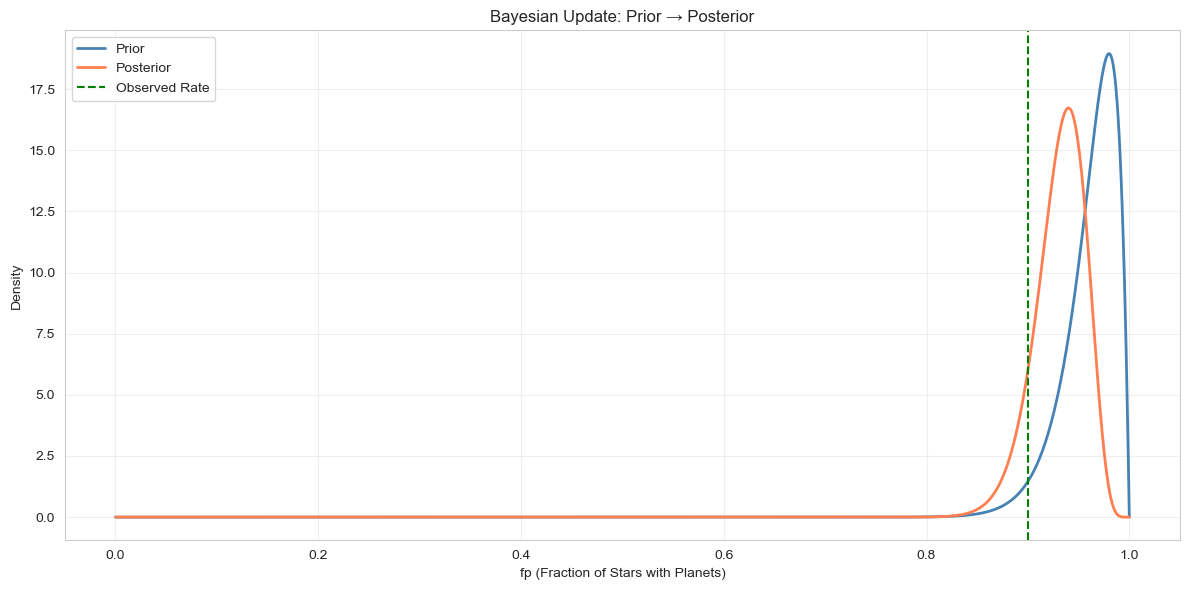

Prior:
  Mean: 0.9615
  Std:  0.0264
  95% CI: [0.8955, 0.9952]

Posterior:
  Mean: 0.9314
  Std:  0.0249
  95% CI: [0.8752, 0.9717]


In [3]:
# ============================================================================
# CELL 2: SIMPLE BAYESIAN UPDATE EXAMPLE
# ============================================================================

# Prior: Beta(50, 2) - strong belief that most stars have planets
prior_alpha = 50
prior_beta = 2

# Simulated observations: 45 out of 50 observed stars have planets
observed_with_planets = 45
observed_total = 50

# Posterior: Beta(prior_alpha + successes, prior_beta + failures)
posterior_alpha = prior_alpha + observed_with_planets
posterior_beta = prior_beta + (observed_total - observed_with_planets)

# Plot prior and posterior
x = np.linspace(0, 1, 1000)
prior = stats.beta(prior_alpha, prior_beta)
posterior = stats.beta(posterior_alpha, posterior_beta)

plt.figure(figsize=(12, 6))
plt.plot(x, prior.pdf(x), label='Prior', linewidth=2, color='steelblue')
plt.plot(x, posterior.pdf(x), label='Posterior', linewidth=2, color='coral')
plt.axvline(observed_with_planets/observed_total, color='green', 
            linestyle='--', label='Observed Rate')
plt.xlabel('fp (Fraction of Stars with Planets)')
plt.ylabel('Density')
plt.title('Bayesian Update: Prior → Posterior')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Prior:")
print(f"  Mean: {prior.mean():.4f}")
print(f"  Std:  {prior.std():.4f}")
print(f"  95% CI: [{prior.ppf(0.025):.4f}, {prior.ppf(0.975):.4f}]")
print("\nPosterior:")
print(f"  Mean: {posterior.mean():.4f}")
print(f"  Std:  {posterior.std():.4f}")
print(f"  95% CI: [{posterior.ppf(0.025):.4f}, {posterior.ppf(0.975):.4f}]")

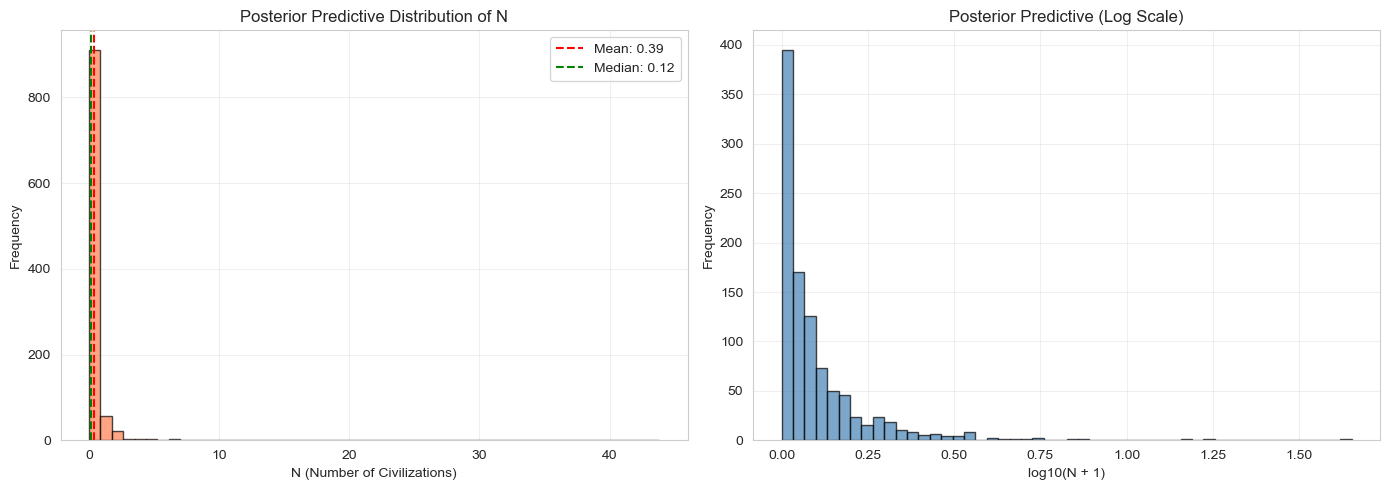


Posterior Predictive Summary for N:
Mean:      0.39
Median:    0.12
Mode:      0.00
Std Dev:   1.63

50% Credible Interval: [0.04, 0.33]
95% Credible Interval: [0.01, 2.05]


In [5]:
# ============================================================================
# CELL 3: BAYESIAN UNCERTAINTY PROPAGATION
# ============================================================================

def bayesian_drake_simulation(n_samples=1000):
    """Sample from posterior distributions of Drake parameters."""
    
    # Define posterior distributions (using informative priors)
    R_star = stats.truncnorm(
        (0.5 - 1.5) / 0.5, (3.0 - 1.5) / 0.5,
        loc=1.5, scale=0.5
    ).rvs(n_samples)
    
    fp = stats.beta(95, 7).rvs(n_samples)  # Updated posterior
    
    ne = stats.lognorm(s=0.5, scale=0.2).rvs(n_samples)
    
    fl = stats.beta(2, 8).rvs(n_samples)  # Pessimistic
    
    fi = stats.beta(2, 20).rvs(n_samples)  # Very uncertain
    
    fc = stats.beta(3, 10).rvs(n_samples)
    
    L = stats.pareto(1.7, scale=100).rvs(n_samples)
    
    # Calculate N
    N = R_star * fp * ne * fl * fi * fc * L
    
    return pd.DataFrame({
        'R_star': R_star, 'fp': fp, 'ne': ne, 'fl': fl,
        'fi': fi, 'fc': fc, 'L': L, 'N': N
    })

# Generate samples
bayes_df = bayesian_drake_simulation()

# Plot posterior predictive distribution of N
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(bayes_df['N'], bins=50, alpha=0.7, edgecolor='black', color='coral')
axes[0].axvline(bayes_df['N'].mean(), color='red', linestyle='--', 
                label=f"Mean: {bayes_df['N'].mean():.2f}")
axes[0].axvline(bayes_df['N'].median(), color='green', linestyle='--',
                label=f"Median: {bayes_df['N'].median():.2f}")
axes[0].set_xlabel('N (Number of Civilizations)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Posterior Predictive Distribution of N')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(np.log10(bayes_df['N'] + 1), bins=50, alpha=0.7, 
             edgecolor='black', color='steelblue')
axes[1].set_xlabel('log10(N + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Posterior Predictive (Log Scale)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Credible intervals
print("\nPosterior Predictive Summary for N:")
print("="*50)
print(f"Mean:      {bayes_df['N'].mean():.2f}")
print(f"Median:    {bayes_df['N'].median():.2f}")
print(f"Mode:      {bayes_df['N'].mode()[0]:.2f}")
print(f"Std Dev:   {bayes_df['N'].std():.2f}")
print(f"\n50% Credible Interval: [{bayes_df['N'].quantile(0.25):.2f}, {bayes_df['N'].quantile(0.75):.2f}]")
print(f"95% Credible Interval: [{bayes_df['N'].quantile(0.025):.2f}, {bayes_df['N'].quantile(0.975):.2f}]")

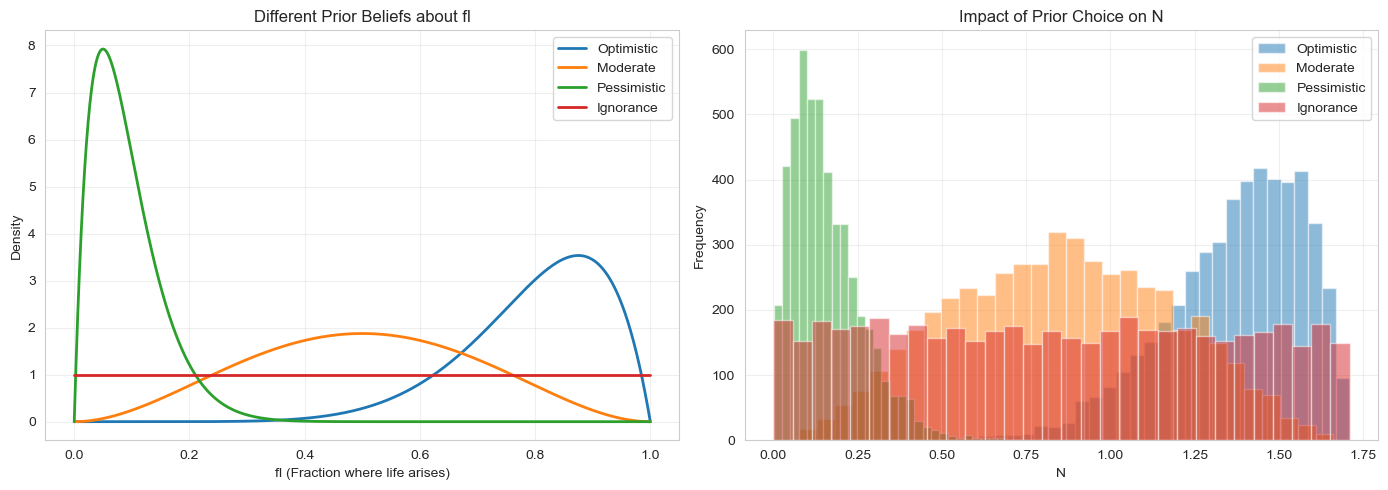


Prior Sensitivity Results:
Optimistic      : Mean N =     1.37, Std =     0.20
Moderate        : Mean N =     0.85, Std =     0.32
Pessimistic     : Mean N =     0.16, Std =     0.11
Ignorance       : Mean N =     0.84, Std =     0.50


In [7]:
# ============================================================================
# CELL 4: PRIOR SENSITIVITY ANALYSIS
# ============================================================================

# Define different priors for fl (life emerging)
priors = {
    'Optimistic': stats.beta(8, 2),    # Most planets develop life
    'Moderate': stats.beta(3, 3),      # 50-50
    'Pessimistic': stats.beta(2, 20),  # Life is rare
    'Ignorance': stats.beta(1, 1)      # Uniform
}

# Calculate N for each prior
results = {}
for prior_name, prior_dist in priors.items():
    fl_samples = prior_dist.rvs(5000)
    # Use median values for other parameters
    N = 1.5 * 0.95 * 0.2 * fl_samples * 0.1 * 0.2 * 300
    results[prior_name] = N

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prior distributions
x = np.linspace(0, 1, 1000)
for prior_name, prior_dist in priors.items():
    axes[0].plot(x, prior_dist.pdf(x), label=prior_name, linewidth=2)
axes[0].set_xlabel('fl (Fraction where life arises)')
axes[0].set_ylabel('Density')
axes[0].set_title('Different Prior Beliefs about fl')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Resulting N distributions
for prior_name, N_vals in results.items():
    axes[1].hist(N_vals, bins=30, alpha=0.5, label=prior_name)
axes[1].set_xlabel('N')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Impact of Prior Choice on N')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPrior Sensitivity Results:")
print("="*50)
for prior_name, N_vals in results.items():
    print(f"{prior_name:15} : Mean N = {N_vals.mean():8.2f}, Std = {N_vals.std():8.2f}")

Hierarchical Bayesian Model Example
Modeling fi (intelligence evolution) across stellar types



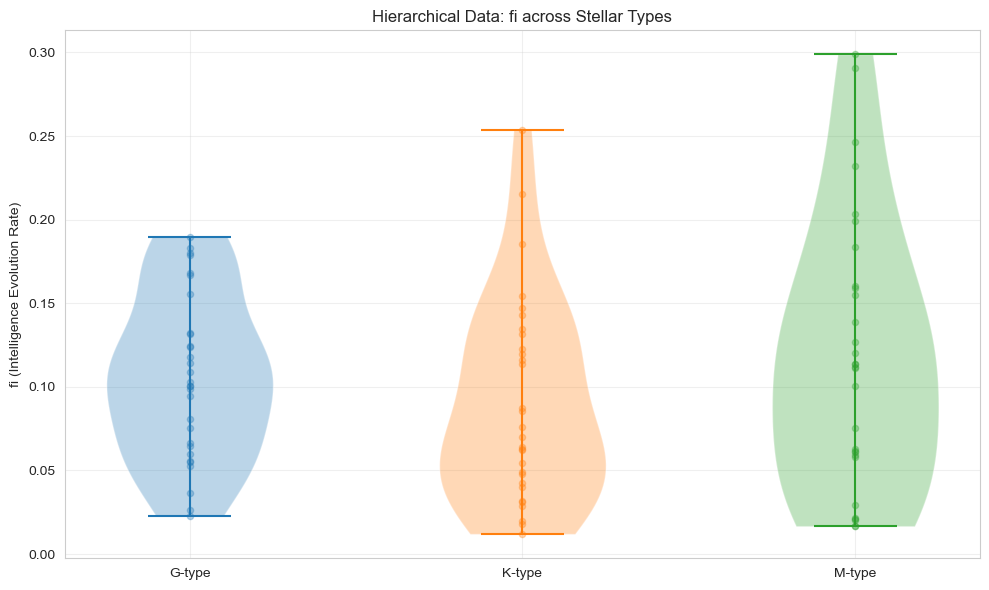


Observed Statistics by Stellar Type:
--------------------------------------------------
G-type     : Mean=0.1056, Std=0.0481
K-type     : Mean=0.0907, Std=0.0599
M-type     : Mean=0.1190, Std=0.0798

[Full hierarchical model with PyMC would provide:
 - Population mean estimate
 - Population variance estimate
 - Group-specific parameters with pooling
 - Uncertainty quantification]


In [9]:
# ============================================================================
# CELL 5: HIERARCHICAL MODEL EXAMPLE
# ============================================================================

# Simulate data: intelligence evolution for different stellar types
stellar_types = ['G-type', 'K-type', 'M-type']
n_obs_per_type = 30

# True parameters (unknown in practice)
true_mu = 0.1
true_sigma = 0.05

# Generate synthetic observations
np.random.seed(42)
observed_fi = {}
for stellar_type in stellar_types:
    # Each stellar type has slightly different mean
    type_mean = true_mu + np.random.normal(0, 0.02)
    observed_fi[stellar_type] = stats.beta(2, 18).rvs(n_obs_per_type)

print("Hierarchical Bayesian Model Example")
print("="*50)
print("Modeling fi (intelligence evolution) across stellar types\n")

# Plot observed data
fig, ax = plt.subplots(figsize=(10, 6))
positions = [1, 2, 3]
for idx, stellar_type in enumerate(stellar_types):
    data = observed_fi[stellar_type]
    ax.violinplot([data], positions=[positions[idx]], widths=0.5)
    ax.scatter([positions[idx]] * len(data), data, alpha=0.3, s=20)

ax.set_xticks(positions)
ax.set_xticklabels(stellar_types)
ax.set_ylabel('fi (Intelligence Evolution Rate)')
ax.set_title('Hierarchical Data: fi across Stellar Types')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObserved Statistics by Stellar Type:")
print("-"*50)
for stellar_type in stellar_types:
    data = observed_fi[stellar_type]
    print(f"{stellar_type:10} : Mean={data.mean():.4f}, Std={data.std():.4f}")

print("\n[Full hierarchical model with PyMC would provide:")
print(" - Population mean estimate")
print(" - Population variance estimate")
print(" - Group-specific parameters with pooling")
print(" - Uncertainty quantification]")

Bayesian Model Comparison
Observed civilization lifetime: 500 years

Model 1 (Short-lived, α=2.5):
  Prior:      0.500
  Likelihood: 0.000089
  Posterior:  0.250

Model 2 (Long-lived, α=1.5):
  Prior:      0.500
  Likelihood: 0.000268
  Posterior:  0.750

Bayes Factor (M1/M2): 0.33
→ Inconclusive evidence


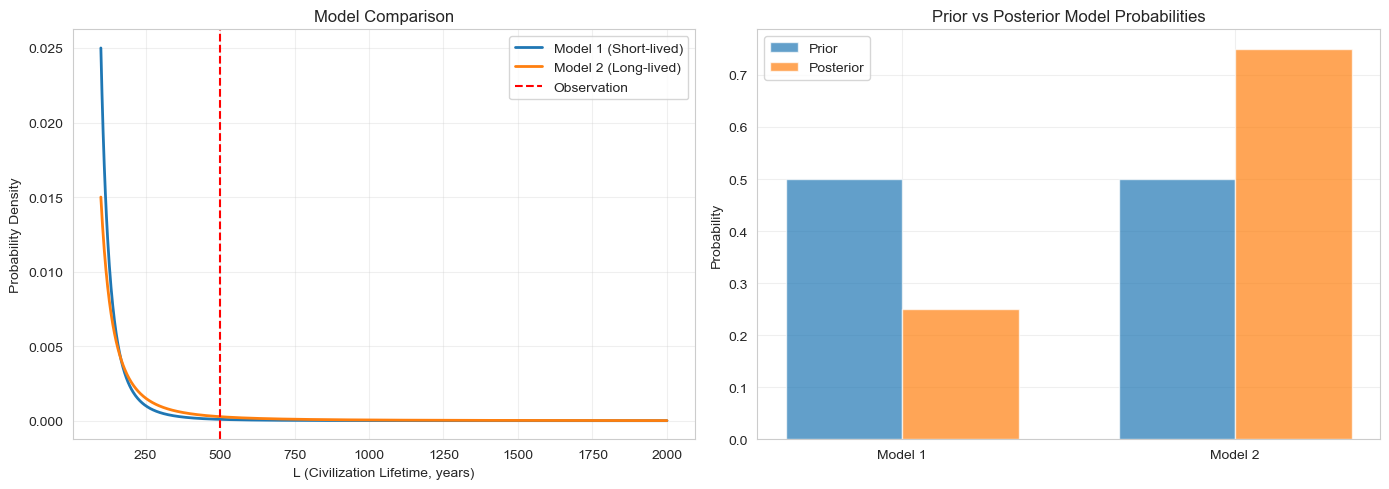

In [11]:
# ============================================================================
# CELL 6: BAYESIAN MODEL COMPARISON
# ============================================================================

# Simple example: Compare two models for L (civilization lifetime)
# Model 1: Short-lived (Pareto with alpha=2.5)
# Model 2: Long-lived (Pareto with alpha=1.5)

# Prior model probabilities
prior_M1 = 0.5
prior_M2 = 0.5

# Simulated observation: We observed a civilization that lasted 500 years
observed_L = 500

# Likelihoods
likelihood_M1 = stats.pareto(b=2.5, scale=100).pdf(observed_L)
likelihood_M2 = stats.pareto(b=1.5, scale=100).pdf(observed_L)

# Posterior model probabilities (Bayes theorem)
marginal = likelihood_M1 * prior_M1 + likelihood_M2 * prior_M2
posterior_M1 = (likelihood_M1 * prior_M1) / marginal
posterior_M2 = (likelihood_M2 * prior_M2) / marginal

# Bayes factor
bayes_factor = (likelihood_M1 / likelihood_M2)

print("Bayesian Model Comparison")
print("="*50)
print(f"Observed civilization lifetime: {observed_L} years\n")
print("Model 1 (Short-lived, α=2.5):")
print(f"  Prior:      {prior_M1:.3f}")
print(f"  Likelihood: {likelihood_M1:.6f}")
print(f"  Posterior:  {posterior_M1:.3f}\n")
print("Model 2 (Long-lived, α=1.5):")
print(f"  Prior:      {prior_M2:.3f}")
print(f"  Likelihood: {likelihood_M2:.6f}")
print(f"  Posterior:  {posterior_M2:.3f}\n")
print(f"Bayes Factor (M1/M2): {bayes_factor:.2f}")

if bayes_factor > 3:
    print("→ Moderate evidence for Model 1")
elif bayes_factor > 10:
    print("→ Strong evidence for Model 1")
elif bayes_factor < 0.33:
    print("→ Moderate evidence for Model 2")
elif bayes_factor < 0.1:
    print("→ Strong evidence for Model 2")
else:
    print("→ Inconclusive evidence")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Model distributions
L_range = np.linspace(100, 2000, 1000)
pdf_M1 = stats.pareto(b=2.5, scale=100).pdf(L_range)
pdf_M2 = stats.pareto(b=1.5, scale=100).pdf(L_range)

axes[0].plot(L_range, pdf_M1, label='Model 1 (Short-lived)', linewidth=2)
axes[0].plot(L_range, pdf_M2, label='Model 2 (Long-lived)', linewidth=2)
axes[0].axvline(observed_L, color='red', linestyle='--', label='Observation')
axes[0].set_xlabel('L (Civilization Lifetime, years)')
axes[0].set_ylabel('Probability Density')
axes[0].set_title('Model Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Prior vs Posterior
models = ['Model 1', 'Model 2']
priors = [prior_M1, prior_M2]
posteriors = [posterior_M1, posterior_M2]

x = np.arange(len(models))
width = 0.35

axes[1].bar(x - width/2, priors, width, label='Prior', alpha=0.7)
axes[1].bar(x + width/2, posteriors, width, label='Posterior', alpha=0.7)
axes[1].set_ylabel('Probability')
axes[1].set_title('Prior vs Posterior Model Probabilities')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

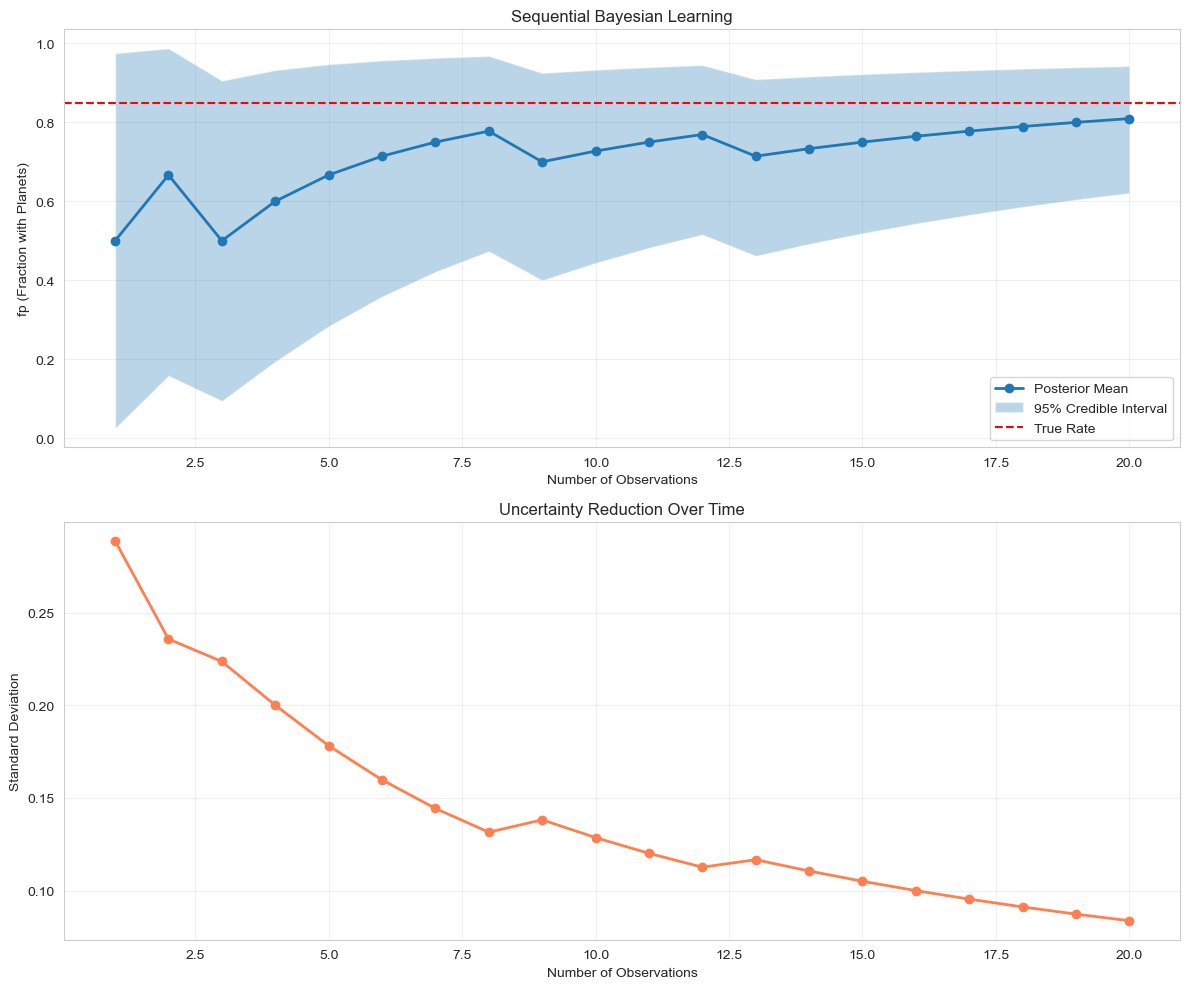


Sequential Learning Summary:
True rate: 0.850
Final estimate: 0.810
Final 95% CI: [0.621, 0.943]
Uncertainty reduction: 71.0%


In [13]:
# ============================================================================
# CELL 7: SEQUENTIAL BAYESIAN UPDATING
# ============================================================================

# Simulate sequential discovery of exoplanets
n_discoveries = 20
true_rate = 0.85  # True fraction with planets

# Generate synthetic discoveries
np.random.seed(42)
discoveries = np.random.binomial(1, true_rate, n_discoveries)

# Start with weak prior
alpha = 1
beta = 1

# Track evolution
evolution = []
for i in range(n_discoveries):
    # Record current belief
    current_dist = stats.beta(alpha, beta)
    evolution.append({
        'observation': i + 1,
        'alpha': alpha,
        'beta': beta,
        'mean': current_dist.mean(),
        'std': current_dist.std(),
        'ci_low': current_dist.ppf(0.025),
        'ci_high': current_dist.ppf(0.975)
    })
    
    # Update with new observation
    if discoveries[i] == 1:
        alpha += 1
    else:
        beta += 1

evolution_df = pd.DataFrame(evolution)

# Plot evolution
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Mean and credible interval
axes[0].plot(evolution_df['observation'], evolution_df['mean'], 
             marker='o', linewidth=2, label='Posterior Mean')
axes[0].fill_between(evolution_df['observation'], 
                      evolution_df['ci_low'], 
                      evolution_df['ci_high'],
                      alpha=0.3, label='95% Credible Interval')
axes[0].axhline(true_rate, color='red', linestyle='--', label='True Rate')
axes[0].set_xlabel('Number of Observations')
axes[0].set_ylabel('fp (Fraction with Planets)')
axes[0].set_title('Sequential Bayesian Learning')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Uncertainty reduction
axes[1].plot(evolution_df['observation'], evolution_df['std'], 
             marker='o', linewidth=2, color='coral')
axes[1].set_xlabel('Number of Observations')
axes[1].set_ylabel('Standard Deviation')
axes[1].set_title('Uncertainty Reduction Over Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSequential Learning Summary:")
print("="*50)
print(f"True rate: {true_rate:.3f}")
print(f"Final estimate: {evolution_df.iloc[-1]['mean']:.3f}")
print(f"Final 95% CI: [{evolution_df.iloc[-1]['ci_low']:.3f}, {evolution_df.iloc[-1]['ci_high']:.3f}]")
print(f"Uncertainty reduction: {(1 - evolution_df.iloc[-1]['std']/evolution_df.iloc[0]['std'])*100:.1f}%")